## Homework №3

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
from datetime import datetime

DEVICE_NAME = 'cuda:0'

now = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
model_name = f'transformer_{now}'

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_to_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_to_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_to_data = './data.txt'

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchtext
from torchtext.data import Field, BucketIterator
from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from tqdm import tqdm
import time
import random

import matplotlib.pyplot as plt
%matplotlib inline

from utils import generate_translation, remove_tech_tokens, get_text, \
                    parse_tensorboard_logs, plot_metrics, beam_search, _len_sort_key, init_weights, count_parameters

In [4]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [5]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05], random_state=random.seed(SEED))

In [8]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [9]:
SRC.build_vocab(train_data, min_freq=3)
TRG.build_vocab(train_data, min_freq=3)

In [10]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9256
Unique tokens in target (en) vocabulary: 6734


Here are tokens from original (RU) corpus:

In [11]:
SRC.vocab.itos[::1000]

['<unk>',
 'террасу',
 'чистые',
 'компьютеры',
 'don',
 'шамони',
 'logis',
 'форму',
 'душевые',
 'техасского']

And from target (EN) corpus:

In [12]:
TRG.vocab.itos[::1000]

['<unk>', 'springs', 'galeao', 'calm', 'occupies', 'tegel', 'malioboro']

And here is example from train dataset:

In [13]:
idx = 9
print(' '.join(train_data.examples[idx].src))
print(' '.join(train_data.examples[idx].trg))

также предлагается доставка продуктов , услуги прачечной и гладильные услуги .
other facilities offered at the property include grocery deliveries , laundry and ironing services .


Let's check the length distributions:

Length distribution in Train data
Max source length: 73
Max target length: 89


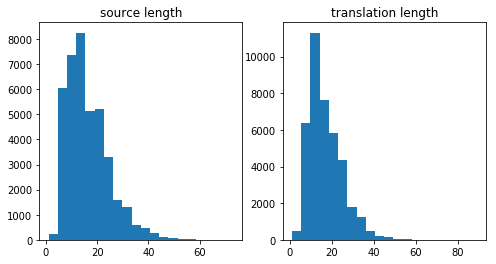

In [14]:
src_length = list(map(len, [x.src for x in train_data.examples]))
trg_length = list(map(len, [x.trg for x in train_data.examples]))

print('Length distribution in Train data')
print(f'Max source length: {max(src_length)}')
print(f'Max target length: {max(trg_length)}')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Validation data
Max source length: 76
Max target length: 73


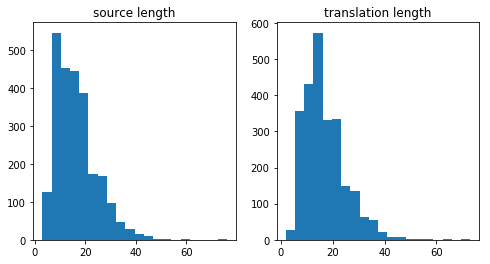

In [15]:
src_length = list(map(len, [x.src for x in valid_data.examples]))
trg_length = list(map(len, [x.trg for x in valid_data.examples]))

print('Length distribution in Validation data')
print(f'Max source length: {max(src_length)}')
print(f'Max target length: {max(trg_length)}')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data
Max source length: 80
Max target length: 99


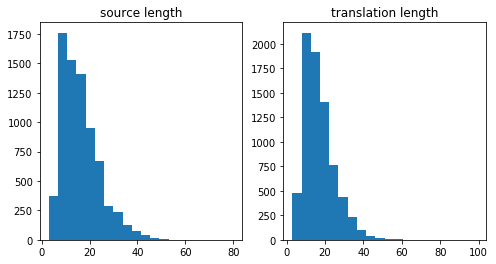

In [16]:
src_length = list(map(len, [x.src for x in test_data.examples]))
trg_length = list(map(len, [x.trg for x in test_data.examples]))

print('Length distribution in Test data')
print(f'Max source length: {max(src_length)}')
print(f'Max target length: {max(trg_length)}')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [17]:
device = torch.device(DEVICE_NAME if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [18]:
MAX_LEN = 60

In [19]:
def eval_bleu(model, test_iterator, target_vocab=TRG.vocab, beam_width=1, with_tqdm=True):
    assert beam_width > 0
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():
        if with_tqdm:
            test_iterator = tqdm(test_iterator, position=0, leave=True)
        for i, batch in enumerate(test_iterator):
            src = batch.src # [src sent len, batch size]
            trg = batch.trg # [trg sent len, batch size]
            
            if beam_width == 1:
                output = model(src, trg, 0) #turn off teacher forcing
                #output = [trg sent len, batch size, output dim]

                output = output.argmax(dim=-1) # [trg sent len, batch size]
            else:
                output = beam_search(model, src, trg, target_vocab, beam_width)  # [trg sent len, batch size]

            original_text.extend([get_text(x, target_vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, target_vocab) for x in output[1:].detach().cpu().numpy().T])
    return corpus_bleu([[text] for text in original_text], generated_text) * 100

In [20]:
def get_teacher_forcing_ratio(epoch, base_teacher_forcing_ratio=0.5, decay=1):
    return base_teacher_forcing_ratio * decay ** epoch

In [21]:
def train(model, iterator, optimizer, criterion, clip, epoch):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):        
        src = batch.src[:MAX_LEN] # [src sent len, batch size]
        trg = batch.trg[:MAX_LEN] # [trg sent len, batch size]
        
        optimizer.zero_grad()        
        teacher_forcing_ratio = get_teacher_forcing_ratio(epoch)
        output = model(src, trg, teacher_forcing_ratio) # [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1]) # [(trg sent len - 1) * batch size, output dim]
        trg = trg[1:].view(-1) # [(trg sent len - 1) * batch size]
        
        loss = criterion(output, trg)        
        loss.backward()
        
        # Let's clip the gradient
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()        
        batch_loss = loss.item()
        epoch_loss += batch_loss
        
    return epoch_loss / len(iterator)

In [22]:
def evaluate(model, iterator, criterion):    
    model.eval()    
    epoch_loss = 0    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
            src = batch.src[:MAX_LEN] # [src sent len, batch size]
            trg = batch.trg[:MAX_LEN] # [trg sent len, batch size]

            output = model(src, trg, 0) #turn off teacher forcing
            # [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1]) # [(trg sent len - 1) * batch size]
            trg = trg[1:].view(-1) # [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [23]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
def training_procedure(model, model_name, train_iterator, valid_iterator,
                      optimizer, lr_scheduler, criterion, writer, clip, n_epochs, beam_width=None):
    best_valid_bleu = float('-inf')
    for epoch in tqdm(range(n_epochs)):    
        start_time = time.time()
        
        train_loss = train(model, train_iterator, optimizer, criterion, clip, epoch)
        valid_loss = evaluate(model, valid_iterator, criterion)
        lr_scheduler.step(valid_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        valid_bleu_greedy = eval_bleu(model, valid_iterator, beam_width=1, with_tqdm=False)
        writer.add_scalar('Validation BLEU (Greedy)',
                    valid_bleu_greedy,
                    epoch)
        
        if beam_width is None:
            valid_bleu_beam = float('-inf')
        else:
            valid_bleu_beam = eval_bleu(model, valid_iterator, beam_width=beam_width, with_tqdm=False)
            writer.add_scalar(f'Validation BLEU (BeamSearch@{beam_width})',
                        valid_bleu_beam,
                        epoch)
        
        max_bleu = max(valid_bleu_greedy, valid_bleu_beam)
        if max_bleu > best_valid_bleu:
            best_valid_bleu = max_bleu
            torch.save(model.state_dict(), f'models/{model_name}.pt')

        writer.add_scalar('Train loss',
                    train_loss,
                    epoch)
        writer.add_scalar('Validation loss',
                    valid_loss,
                    epoch)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')
        if beam_width is None:
            print(f'\tVal. BLEU (Greedy): {valid_bleu_greedy:.3f}')
        else:
            print(f'\tVal. BLEU (Greedy): {valid_bleu_greedy:.3f} | Val. BLEU (BeamSearch@{beam_width}): {valid_bleu_beam:.3f}')

In [25]:
def get_tensorboard_dir(model_name):
    return f'runs/{model_name}'

In [26]:
def print_samples(model, test_iterator, indices=range(0, 10), beam_widths=[2,10]):
    batch = next(iter(test_iterator))
    for idx in indices:
        src = batch.src[:, idx:idx+1]
        trg = batch.trg[:, idx:idx+1]
        generate_translation(src, trg, model, TRG.vocab, beam_widths)

## Let's use Transformer

In [27]:
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [28]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
N_HEADS = 4
N_LAYERS = 4
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

LR = 0.5e-3
CLIP = 1
N_EPOCHS = 10

In [29]:
import torch
import torch.nn as nn
from torchnlp.nn.attention import Attention

import random


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_heads, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=hid_dim
        )
        
        self.pos_encoder = PositionalEncoding(hid_dim, dropout)
        encoder_layers = nn.TransformerEncoderLayer(hid_dim, n_heads, hid_dim, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, n_layers)
        
    def forward(self, src, key_padding_mask=None):        
        # src = [src sent len, batch size]
        # key_padding_mask = [batch size, src sent len]
        embedded = self.embedding(src) * np.sqrt(self.hid_dim) # [src sent len, batch size, hid dim]
        embedded = self.pos_encoder(embedded)
        
        # [src sent len, batch size, hid dim]
        output = self.transformer_encoder(embedded, src_key_padding_mask=key_padding_mask)
        
        return output

In [30]:
class TransformerDecoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_heads, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_heads = n_heads
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=hid_dim
        )
        
        self.pos_encoder = PositionalEncoding(hid_dim, dropout)
        decoder_layers = nn.TransformerDecoderLayer(hid_dim, n_heads, hid_dim, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, n_layers)
        
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
        
    def forward(self, input, encoder_outputs, key_padding_mask=None):        
        # input = [src prefix len, batch size]
        # encoder_outputs = [src sent len, batch size, hid dim]
        
        embedded = self.embedding(input) * np.sqrt(self.hid_dim) # [src prefix len, batch size, hid dim]
        embedded = self.pos_encoder(embedded) # [src prefix len, batch size, hid dim]
        
        # [src prefix len, batch size, hid dim]
        outputs = self.transformer_decoder(embedded, encoder_outputs, tgt_key_padding_mask=key_padding_mask)
        
        output = self.out(outputs[-1]) # [batch size, output dim]
        return output


class TransformerSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
    
    def apply_encoder(self, src):
        # src = [src sent len, batch size]
        
        key_padding_mask = (src == self.src_pad_idx).transpose(1,0)
        enc_output = self.encoder(src, key_padding_mask=key_padding_mask)
        return enc_output # [src sent len, batch size, emb dim]
    
    def forward(self, src, trg, teacher_forcing_ratio=0.5):        
        # src = [src sent len, batch size]
        # trg = [trg sent len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # encoder_output = [src sent len, batch size, hid dim]
        encoder_output = self.apply_encoder(src)
        decoder_outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        decoder_inputs = torch.full((max_len, batch_size), self.trg_pad_idx, dtype=torch.long, device=self.device)
        
        # first input to the decoder is the <sos> tokens
        decoder_inputs[0,:] = trg[0,:]
        
        for t in range(1, max_len):
            input = decoder_inputs[:t].clone().detach()
            key_padding_mask = (input == self.trg_pad_idx).transpose(1,0)
            
            # output = [batch size, output dim]
            output = self.decoder(input, encoder_output, key_padding_mask)
            decoder_outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.detach().max(1)[1]
            decoder_inputs[t] = (trg[t] if teacher_force else top1)
        
        return decoder_outputs

In [31]:
SRC_PAD_IDX = SRC.vocab.stoi['<pad>']
TRG_PAD_IDX = TRG.vocab.stoi['<pad>']

In [32]:
# from models import GruEncoder, AttentionGruDecoder, AttentionGruSeq2Seq
enc = TransformerEncoder(INPUT_DIM, HID_DIM, N_HEADS, N_LAYERS, ENC_DROPOUT)
dec = TransformerDecoder(OUTPUT_DIM, HID_DIM, N_HEADS, N_LAYERS, DEC_DROPOUT)
model = TransformerSeq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [33]:
count_parameters(model)

10045006

In [34]:
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.001, amsgrad=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [35]:
tensorboard_dir = get_tensorboard_dir(model_name)
print(tensorboard_dir)
writer = SummaryWriter(tensorboard_dir)
training_procedure(model, model_name, train_iterator, valid_iterator,
                      optimizer, lr_scheduler, criterion, writer, clip=CLIP, n_epochs=N_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

runs/transformer_2020-05-29--22-19-26


 10%|█         | 1/10 [21:11<3:10:46, 1271.86s/it]

Epoch: 01 | Time: 20m 57s
	Train Loss: 4.482 | Train PPL:  88.372
	 Val. Loss: 4.812 |  Val. PPL: 122.933
	Val. BLEU (Greedy): 9.106


 20%|██        | 2/10 [42:26<2:49:42, 1272.84s/it]

Epoch: 02 | Time: 20m 59s
	Train Loss: 3.670 | Train PPL:  39.259
	 Val. Loss: 4.693 |  Val. PPL: 109.203
	Val. BLEU (Greedy): 12.820


 30%|███       | 3/10 [1:03:43<2:28:37, 1273.86s/it]

Epoch: 03 | Time: 21m 1s
	Train Loss: 3.394 | Train PPL:  29.771
	 Val. Loss: 4.674 |  Val. PPL: 107.075
	Val. BLEU (Greedy): 13.732


 40%|████      | 4/10 [1:25:04<2:07:36, 1276.16s/it]

Epoch: 04 | Time: 21m 6s
	Train Loss: 3.230 | Train PPL:  25.275
	 Val. Loss: 4.484 |  Val. PPL:  88.622
	Val. BLEU (Greedy): 14.983


 50%|█████     | 5/10 [1:46:19<1:46:18, 1275.63s/it]

Epoch: 05 | Time: 20m 59s
	Train Loss: 3.116 | Train PPL:  22.550
	 Val. Loss: 4.507 |  Val. PPL:  90.615
	Val. BLEU (Greedy): 16.063


 60%|██████    | 6/10 [2:07:30<1:24:57, 1274.48s/it]

Epoch: 06 | Time: 20m 57s
	Train Loss: 3.046 | Train PPL:  21.030
	 Val. Loss: 4.504 |  Val. PPL:  90.360
	Val. BLEU (Greedy): 16.596


 70%|███████   | 7/10 [2:28:46<1:03:44, 1274.77s/it]

Epoch: 07 | Time: 21m 0s
	Train Loss: 2.983 | Train PPL:  19.752
	 Val. Loss: 4.381 |  Val. PPL:  79.907
	Val. BLEU (Greedy): 17.051


 80%|████████  | 8/10 [2:49:48<42:21, 1270.95s/it]  

Epoch: 08 | Time: 20m 46s
	Train Loss: 2.898 | Train PPL:  18.136
	 Val. Loss: 4.520 |  Val. PPL:  91.846
	Val. BLEU (Greedy): 17.323


 90%|█████████ | 9/10 [3:11:17<21:16, 1276.54s/it]

Epoch: 09 | Time: 21m 14s
	Train Loss: 2.833 | Train PPL:  16.990
	 Val. Loss: 4.472 |  Val. PPL:  87.504
	Val. BLEU (Greedy): 17.714


100%|██████████| 10/10 [3:32:32<00:00, 1275.84s/it]

Epoch: 10 | Time: 20m 56s
	Train Loss: 2.796 | Train PPL:  16.377
	 Val. Loss: 4.573 |  Val. PPL:  96.828
	Val. BLEU (Greedy): 19.016


**Let's load best model**

In [36]:
with open(f'models/{model_name}.pt', 'rb') as fp:
    best_state_dict = torch.load(fp, map_location='cpu')
    model.load_state_dict(best_state_dict)

**And look at its predictions**

In [37]:
print_samples(model, test_iterator)

Original:                   towels are featured .
Generated (Greedy):         towels are provided .


ValueError: too many values to unpack (expected 2)

In [ ]:
print('Test BLEU (Greedy):', eval_bleu(model, test_iterator, beam_width=1))

In [ ]:
print('Test BLEU (BeamSearch@2):', eval_bleu(model, test_iterator, beam_width=2))

In [ ]:
print('Test BLEU (BeamSearch@5):', eval_bleu(model, test_iterator, beam_width=5))

In [ ]:
print('Test BLEU (BeamSearch@10):', eval_bleu(model, test_iterator, beam_width=10))

In [ ]:
print('Test BLEU (BeamSearch@16):', eval_bleu(model, test_iterator, beam_width=16))

In [ ]:
print('Test BLEU (BeamSearch@32):', eval_bleu(model, test_iterator, beam_width=32))

**And plot train/val metrics**

In [ ]:
logs = parse_tensorboard_logs(tensorboard_dir)

In [ ]:
printable_model_name = '_'.join(model_name.split('_')[:-1])

In [ ]:
plot_metrics(logs, printable_model_name)